In [1]:
# %pip install torchmetrics

# Metrics for RPN and GCViT

In [2]:
from torch import Tensor
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, z_score_normalization
from project.utils import collatev2, compute_statistics
import winsound
from torchvision.models import resnet18, ResNet18_Weights
from project.utils import memcheck
from project.evaluation import isa_rpn_metric

In [3]:
ds = Dataset()

data = pd.read_csv('targets.csv')
data.shape

(7986, 7)

In [4]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,target,has_microbleed_case,has_microbleed_slice,cohort,max_value
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,1,1,1,928.405273
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,1,1,1,928.405273
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,1,1,1,928.405273
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,1,1,1,928.405273
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,1,1,1,928.405273
...,...,...,...,...,...,...,...
359,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,241.000000
360,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,26,1,1,3,241.000000
361,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,24,1,1,3,448.000000
362,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,25,1,1,3,448.000000


In [5]:
ch1 = ds.load_raw_mri(1)
data = data[data.mri.isin(ch1)]
data.shape

(45, 7)

In [6]:
cases = data.mri
masks = data.masks
target = data.target

global_min, global_max = compute_statistics(data.mri.tolist())

# global_min = 0.0
# global_max = 1417.92822265625

In [7]:
global_min, global_max

(0.0, 1417.92822265625)

In [8]:
image_size = 300

In [9]:
transform = NiftiToTensorTransform(
    target_shape = (image_size, image_size), 
    rpn_mode=True,
    normalization=(global_min, global_max)
)

In [10]:
dataset = VALDODataset(
    cases=data.mri,
    masks=data.masks,
    target=data.target,
    transform=transform,
)

dataset_loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=1,
    collate_fn=collatev2,
)


## RPN metrics

In [11]:
from project.model import RPN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

rpn_model = RPN(
    input_dim=512,
    output_dim=4,
    image_size=image_size,
    nh=4
).to(device)

324


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
rpn_model.load_state_dict(torch.load('RPN_test15_weights_Nov_02_2024_192506.pt'))

<All keys matched successfully>

### IOU

In [13]:
# from torchmetrics.functional.detection import intersection_over_union
# from torchvision.ops import box_area
# from typing import Tuple


In [14]:
# def _upcast(t: Tensor) -> Tensor:
#     # Protects from numerical overflows in multiplications by upcasting to the equivalent higher type
#     if t.is_floating_point():
#         return t if t.dtype in (torch.float32, torch.float64) else t.float()
#     else:
#         return t if t.dtype in (torch.int32, torch.int64) else t.int()

# def _box_inter_union(boxes1: Tensor, boxes2: Tensor) -> Tuple[Tensor, Tensor]:
#     area1 = box_area(boxes1)
#     area2 = box_area(boxes2)

#     lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
#     rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]

#     wh = _upcast(rb - lt).clamp(min=0)  # [N,M,2]
#     inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

#     union = area1[:, None] + area2 - inter

#     return inter, union

In [15]:
iou_scores = []
preds = []
truth = []
cases = []
targets = []
precision_scores = []
recall_scores = []
f1_scores = []
counter = 0

with torch.no_grad():
    for batch in enumerate(dataset_loader):
        slices, masks, target, case = batch[1][0]
        x = slices.squeeze(1).float().to(device)
        T = masks.squeeze(1).float().to(device)/image_size

        y = rpn_model(x, target)

        preds.append((y *  image_size).squeeze().detach().cpu().numpy())
        truth.append((T[target] * image_size).squeeze().detach().cpu().numpy())
        cases.append(case)
        targets.append(target)

        iou_score, precision_score, recall_score, f1_score = isa_rpn_metric(image_size=image_size, target_bbox=T[target], predicted_bbox=y)

        # iou_score = intersection_over_union(y * image_size, T[target] * image_size)
        

        # inter, union = _box_inter_union(y * image_size, T[target] * image_size)

        # precision_score = (inter / box_area(y * image_size))
        # recall_score = (inter / box_area(T[target] * image_size))

        # if any([precision_score, recall_score]) == 0:
        #     f1_score = 0
        #     f1_scores.append(f1_score)
        # else:
        #     f1_score = (2 * (precision_score * recall_score)) / (precision_score + recall_score)
        #     f1_scores.append(f1_score.detach().cpu().numpy())
        
        print(f'{counter} IOU score:', iou_score)
        print(f'{counter} Precision score:', precision_score)
        print(f'{counter} Recall score:', recall_score)
        print(f'{counter} F1 score:', f1_score)

        print()

        iou_scores.append(iou_score.detach().cpu().numpy())
        precision_scores.append(precision_score.squeeze().squeeze().detach().cpu().numpy())
        recall_scores.append(recall_score.squeeze().squeeze().detach().cpu().numpy())
        f1_scores.append(f1_score)
        counter += 1


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


0 IOU score: tensor(0.5792, device='cuda:0')
0 Precision score: tensor([[0.6958]], device='cuda:0')
0 Recall score: tensor([[0.7755]], device='cuda:0')
0 F1 score: [[0.73351914]]

1 IOU score: tensor(0.2756, device='cuda:0')
1 Precision score: tensor([[0.2756]], device='cuda:0')
1 Recall score: tensor([[1.]], device='cuda:0')
1 F1 score: [[0.43207932]]

2 IOU score: tensor(0.1845, device='cuda:0')
2 Precision score: tensor([[0.1973]], device='cuda:0')
2 Recall score: tensor([[0.7403]], device='cuda:0')
2 F1 score: [[0.31150413]]

3 IOU score: tensor(0.1672, device='cuda:0')
3 Precision score: tensor([[0.2650]], device='cuda:0')
3 Recall score: tensor([[0.3119]], device='cuda:0')
3 F1 score: [[0.2865574]]

4 IOU score: tensor(0.0993, device='cuda:0')
4 Precision score: tensor([[0.1387]], device='cuda:0')
4 Recall score: tensor([[0.2591]], device='cuda:0')
4 F1 score: [[0.18068425]]

5 IOU score: tensor(0.6946, device='cuda:0')
5 Precision score: tensor([[0.8551]], device='cuda:0')
5 Rec

In [17]:
score_dict = {
    'Case': cases,
    'Target': targets,
    'Ground_Truth': truth,
    'Predictions': preds,
    'IOU': iou_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores
}

score_df = pd.DataFrame(score_dict)

In [18]:
score_df

,Case,Target,Ground_Truth,Predictions,IOU,Precision,Recall,F1
0,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,8,"[66.796875, 145.89844, 137.10938, 226.17188]","[73.7135, 111.33514, 129.07475, 224.9656]",0.579179,0.6958271,0.7755284,[[0.73351914]]
1,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,9,"[121.28906, 158.20312, 181.64062, 219.14062]","[78.45162, 120.365234, 194.25781, 235.6049]",0.2755747,0.2755747,1.0,[[0.43207932]]
2,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,11,"[133.59375, 172.85156, 193.94531, 233.20312]","[73.740204, 105.18836, 195.424, 217.53094]",0.18448618,0.1972507,0.74031854,[[0.31150413]]
3,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,12,"[107.22656, 154.10156, 183.39844, 219.14062]","[77.085464, 119.99229, 130.98466, 228.16571]",0.16724075,0.26502272,0.31190124,[[0.2865574]]
4,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,15,"[61.523438, 80.859375, 123.046875, 141.79688]","[88.850624, 113.38925, 170.19785, 199.48627]",0.0993144,0.13870195,0.2591124,[[0.18068425]]
5,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,16,"[122.46094, 97.265625, 191.01562, 208.59375]","[118.17247, 88.12998, 183.0823, 196.37283]",0.6945621,0.8551085,0.78720695,[[0.81975406]]
6,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,17,"[127.734375, 103.125, 192.77344, 204.49219]","[127.096405, 132.02747, 190.5167, 177.47408]",0.43088505,0.9899406,0.43278,[[0.6022637]]
7,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,27,"[119.53125, 148.24219, 180.46875, 209.76562]","[31.098774, 87.43395, 126.959496, 211.9021]",0.030019762,0.038302574,0.12189941,[[0.058289684]]
8,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,17,"[114.84375, 155.85938, 178.71094, 219.72656]","[113.21993, 111.82598, 198.16989, 173.7688]",0.13953789,0.21737283,0.2804167,[[0.2449026]]
9,c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...,5,"[48.046875, 133.59375, 110.15625, 195.11719]","[52.318356, 151.14636, 124.52201, 207.24234]",0.47729337,0.62789375,0.66554797,[[0.64617276]]


#### Average IOU score

In [19]:
avg = sum(iou_scores) / len(iou_scores)
print(avg)

0.3184425743089782


#### Average Precision score

In [20]:
avg = sum(precision_scores) / len(precision_scores)
print(avg)

0.4728527529992991


#### Average Recall score

In [21]:
avg = sum(recall_scores) / len(recall_scores)
print(avg)

0.5251390498545435


#### Average F1 score

In [22]:
avg = sum(f1_scores) / len(f1_scores)
print(avg)

[[0.4508708]]


#### Plotting of highest score

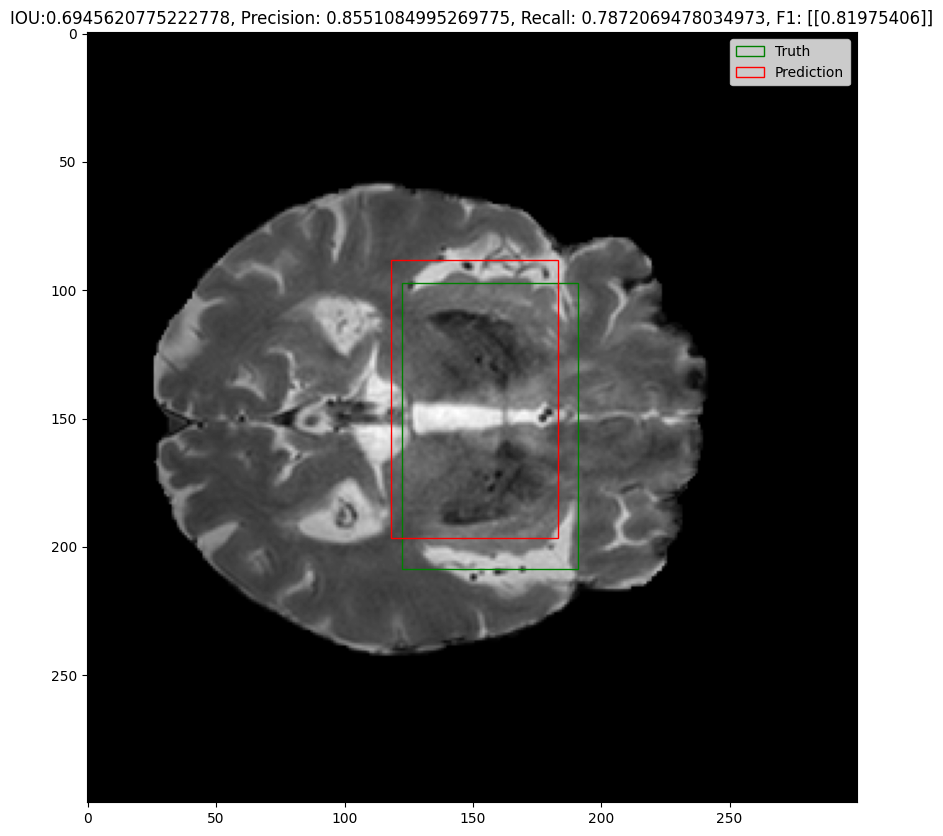

In [26]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

num = iou_scores.index(max(iou_scores))

slices, masks, target, case = dataset[num]

truth_bbox = truth[num]
predicted_bbox = preds[num]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.imshow(slices[target][0, 0, :], cmap='gray')
# Create the bounding box rectangle
truth_rect = patches.Rectangle(
    (truth_bbox[0], truth_bbox[1]),  # (x_min, y_min)
    truth_bbox[2] - truth_bbox[0],   # width
    truth_bbox[3] - truth_bbox[1],   # height
    linewidth=1, edgecolor='g', facecolor='none',  # red bounding box
    label='Truth'
)

# Create the bounding box rectangle
predicted_rect = patches.Rectangle(
    (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
    predicted_bbox[2] - predicted_bbox[0],   # width
    predicted_bbox[3] - predicted_bbox[1],   # height
    linewidth=1, edgecolor='r', facecolor='none',  # red bounding box
    label='Prediction'
)

ax.set_title(f'IOU:{iou_scores[num]}, Precision: {precision_scores[num]}, Recall: {recall_scores[num]}, F1: {f1_scores[num]}')

# Add the rectangle to the axis
ax.add_patch(truth_rect)
ax.add_patch(predicted_rect)

ax.legend()